# Finding Lane Lines on the Road



In [1]:
!pip install PyGitHub --user

In [2]:
!pip install opencv-python

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

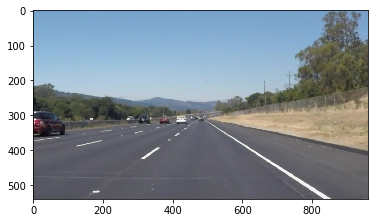

In [5]:
image = (mpimg.imread('https://github.com/retkowsky/SelfDrivingCars/blob/master/solidWhiteRight.png?raw=true')*255).astype('uint8')

plt.imshow(image)

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform
    Canny recommends a upper:lower ratio between 2:1 and 3:1"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channle color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero 
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #collect y-min and y-max using for left and right lines
    #look for (-) slope for left lines and (+) slope for right lines    
    ymin_left, ymin_right = [], []
    ymax_left, ymax_right = [], []
    
    xmin_left, xmin_right = 0, int(img.shape[1]/2)+20
    xmax_left, xmax_right = int(img.shape[1]/2)-20, img.shape[1] 

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            intercept = y1 - slope * x1
            if slope < 0:   # negative slope: line coordinates belongs to left line
                ymin_left += [intercept]
                ymax_left += [slope * xmax_left + (intercept)]
            elif slope > 0: # positive slope: line coordinates belongs to right line
                ymin_right += [slope * xmin_right + (intercept)]
                ymax_right += [slope * xmax_right + (intercept)]
                
    #compute average ymin and ymax for left and right lines
    avg_ymin_left, avg_ymin_right = np.mean(ymin_left), np.mean(ymin_right)
    avg_ymax_left, avg_ymax_right = np.mean(ymax_left), np.mean(ymax_right)
    
    #draw left and right lines
    if (ymin_left and ymax_left):       #safe gaurds for empty NaN mean
        cv2.line(img, (xmin_left, int(avg_ymin_left)), (xmax_left, int(avg_ymax_left)), color, thickness)
    if (ymin_right and ymax_right):     #safe gaurds for empty NaN mean
        cv2.line(img, (xmin_right, int(avg_ymin_right)), (xmax_right, int(avg_ymax_right)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape,3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=8)
    return line_img
    
#python 3 has support for cool math symbols

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images


In [7]:
array_of_images = ['https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteCurve.png',
 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidYellowCurve.png',
 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidYellowLeft.png',
 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteCurve.png',
 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteRight.png',
 'https://github.com/retkowsky/SelfDrivingCars/raw/master/whiteCarLaneSwitch.png']
print(array_of_images)

['https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteCurve.png', 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidYellowCurve.png', 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidYellowLeft.png', 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteCurve.png', 'https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteRight.png', 'https://github.com/retkowsky/SelfDrivingCars/raw/master/whiteCarLaneSwitch.png']


### Build Pipeline to Process Images to Find Lanes
The function called lane_finder contains the steps to process image
Detailed description of how the pipeline works can be found in the reflection section

In [8]:
def read_image(file_name):
    ''' 
    Function reads image base on file type 
    '''
    image = (mpimg.imread(file_name)*255).astype('uint8')
    return image

def lane_finder(image):
    ''' 
    Function applies Canny Edge Detection and Hough Transform
    to draw lanes on the road in an image.
    '''
    #gray scale image
    gray = grayscale(image)
    
    #define kernel size apply Gaussian Smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #define parameters for Canny Edge Detection and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    #create a masked edges image to isolate the region of interest
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    #define vertices of the masking polygon
    v1 = (0, image_height)
    v2 = (int(image_width/2 - image_width*.01), image_height/2 + int(image_height*.08))
    v3 = (int(image_width/2 + image_width*.01), image_height/2 + int(image_height*.08))
    v4 = (image_width, image_height)
    vertices = np.array([[v1, v2, v3, v4]], dtype=np.int32)
    
    #apply mask
    masked_edges = region_of_interest(edges, vertices)
    
    #define the Hough Transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 45
    max_line_gap = 15
    
    #run Hough Transform on the edge detected image to find lines
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    #draw the lines on the original image
    lane_lines = weighted_img(lines, image)
    return lane_lines

### The Pipeline at Work with Test Images

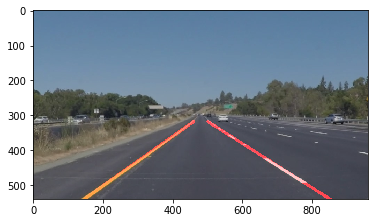

In [10]:
test_images = array_of_images
image=test_images[2]
plt.imshow(lane_finder(read_image(image)))


https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteCurve.png
https://github.com/retkowsky/SelfDrivingCars/raw/master/solidYellowCurve.png
https://github.com/retkowsky/SelfDrivingCars/raw/master/solidYellowLeft.png
https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteCurve.png
https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteRight.png
https://github.com/retkowsky/SelfDrivingCars/raw/master/whiteCarLaneSwitch.png


<Figure size 432x288 with 0 Axes>

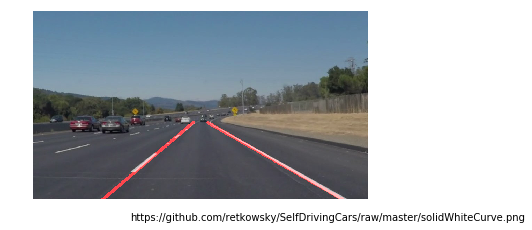

<Figure size 432x288 with 0 Axes>

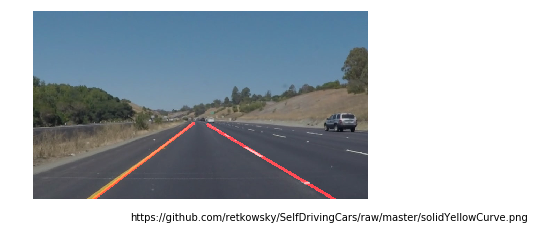

<Figure size 432x288 with 0 Axes>

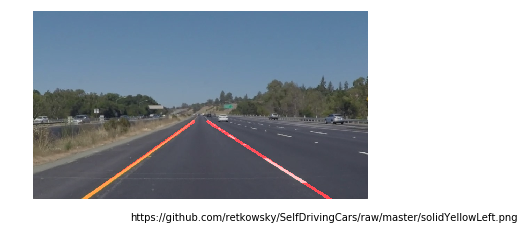

<Figure size 432x288 with 0 Axes>

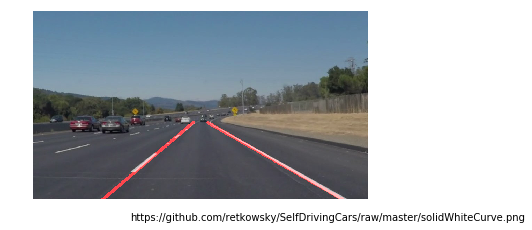

<Figure size 432x288 with 0 Axes>

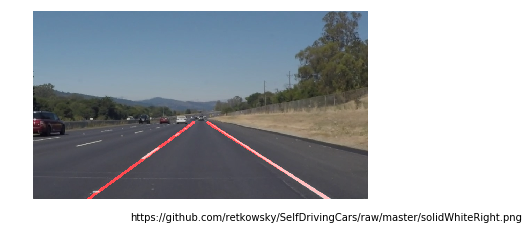

<Figure size 432x288 with 0 Axes>

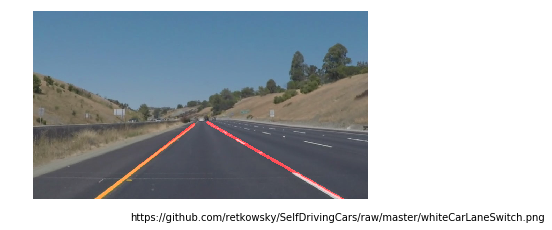

In [11]:
#process all test images
output_images = []
for image in test_images:
    print(image)
    plt.figure()
    plt.figure().text(.35,.1,image)
    plt.axis('off')
    plt.imshow(lane_finder(read_image(image)))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [12]:
!pip install moviepy

In [13]:
import imageio
imageio.plugins.ffmpeg.download()

In [14]:
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return lane_finder(image)

In [16]:
HTML("""
<video width="640" height="380" controls>
  <source src="https://github.com/retkowsky/SelfDrivingCars/raw/master/solidWhiteRight.mp4">
</video>
""")

In [17]:
HTML("""
<video width="640" height="380" controls>
  <source src="https://github.com/retkowsky/SelfDrivingCars/raw/master/white.mp4">
</video>
""")

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="https://github.com/retkowsky/SelfDrivingCars/raw/master/yellow.mp4">
</video>
""")